In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

2024-03-06 13:35:25.476658: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 13:35:25.816865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 13:35:25.816895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 13:35:25.817857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 13:35:25.840617: I tensorflow/core/platform/cpu_feature_guar

READ DATA

In [3]:
(train_data, test_data), ds_info = tfds.load(name="emnist/digits",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned in tuple format (data, label)
                                             with_info=True)

2024-03-05 21:28:01.940234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 21:28:01.940345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 21:28:01.940392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 21:28:02.394443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 21:28:02.394559: I external/local_xla/xla/stream_executor

In [4]:
train_data = train_data.concatenate(test_data)

In [5]:
dataset = []
label_var = []
for image, label in tfds.as_numpy(train_data):
  if label not in label_var: label_var.append(label)
  dataset.append({
      'image' : image,
      'label' : int(label)
  })

In [6]:
dataset_per_label = []
for label in label_var:
  dataset_per_label.append([])

for number in dataset:
  dataset_per_label[number['label']].append(number)

In [7]:
percentage = 10
new_data = []

for label in dataset_per_label:
  num = int(len(label) * percentage / 100)
  new_data.append(np.random.choice(label, num, replace=False))

for i in range(len(new_data)):
  print(i, len(new_data[i]))

0 2800
1 2800
2 2800
3 2800
4 2800
5 2800
6 2800
7 2800
8 2800
9 2800


In [8]:
new_data = np.array(new_data)

In [9]:
new_data=new_data.flatten()

In [10]:
len(new_data)

28000

In [3]:
import pickle

In [12]:
with open('dataset.pkl', 'wb') as f:
    pickle.dump(new_data, f)

In [13]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [14]:
X = []
Y = []
for i in range(len(new_data)):
  X.append(tf.cast(new_data[i]['image'], tf.float32) / 255)
  Y.append(tf.one_hot(new_data[i]['label'], depth=10))

X = np.array(X)
Y = np.array(Y)

In [15]:
with open('datax.pkl','wb') as f:
    pickle.dump(X, f)

with open('datay.pkl','wb') as f:
    pickle.dump(Y, f)

In [ ]:
with open('datax.pkl','rb') as f:
    X = pickle.load(f)
with open('datay.pkl','rb') as f:
    Y = pickle.load(f)

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
with open('x_train.pkl','wb') as f:
    pickle.dump(Xtrain, f)

with open('y_train.pkl','wb') as f:
    pickle.dump(Ytrain, f)

with open('x_test.pkl','wb') as f:
    pickle.dump(Xtest, f)

with open('y_test.pkl','wb') as f:
    pickle.dump(Ytest, f)

In [4]:
with open('x_train.pkl','rb') as f:
    Xtrain = pickle.load(f)
with open('y_train.pkl','rb') as f:
    Ytrain = pickle.load(f)

with open('x_test.pkl','rb') as f:
    Xtest = pickle.load(f)
with open('y_test.pkl','rb') as f:
    Ytest = pickle.load(f)

Data Plotting

In [5]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

Alexnet

In [19]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(28,28,1)),
        keras.layers.Conv2D(96, kernel_size=(3,3), strides=(1,1), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(256, kernel_size=(5,5), activation='relu',padding='same'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(384, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.Conv2D(384, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu',padding='same'),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 384)         1

In [20]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [21]:
history_alexnet = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10


2024-03-05 21:30:07.950445: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-05 21:30:08.461865: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 21:30:09.673632: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 21:30:10.246934: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb427469860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 21:30:10.246978: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-05 21:30:10.259093: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709649010.357097  228582 devic

1400/1400 [==============================] - 23s 13ms/step - loss: 0.3790 - accuracy: 0.8759 - val_loss: 0.1070 - val_accuracy: 0.9752
Epoch 2/10
1400/1400 [==============================] - 44s 32ms/step - loss: 0.1224 - accuracy: 0.9712 - val_loss: 0.1499 - val_accuracy: 0.9652
Epoch 3/10
1400/1400 [==============================] - 45s 32ms/step - loss: 0.0999 - accuracy: 0.9774 - val_loss: 0.0833 - val_accuracy: 0.9798
Epoch 4/10
1400/1400 [==============================] - 44s 32ms/step - loss: 0.0941 - accuracy: 0.9790 - val_loss: 0.0882 - val_accuracy: 0.9795
Epoch 5/10
1400/1400 [==============================] - 46s 33ms/step - loss: 0.0871 - accuracy: 0.9807 - val_loss: 0.0763 - val_accuracy: 0.9827
Epoch 6/10
1400/1400 [==============================] - 54s 39ms/step - loss: 0.0584 - accuracy: 0.9860 - val_loss: 0.0943 - val_accuracy: 0.9809
Epoch 7/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.0818 - accuracy: 0.9836 - val_loss: 0.0884 - val_accura

In [22]:
with open('history_alexnet.pkl', 'wb') as f:
    pickle.dump(history_alexnet, f)

In [ ]:
with open('data_100persen/history_alexnet.pkl', 'rb') as f:
    history_alexnet = pickle.load(f)

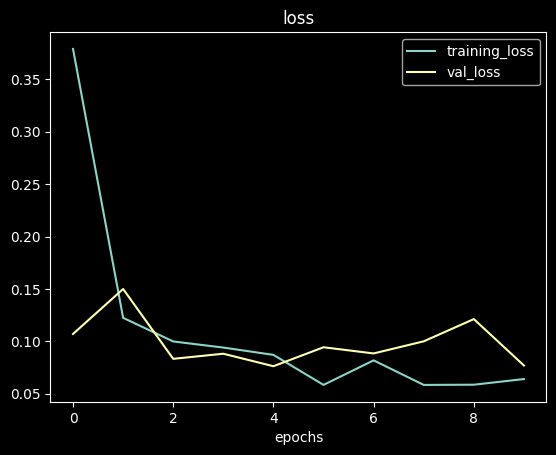

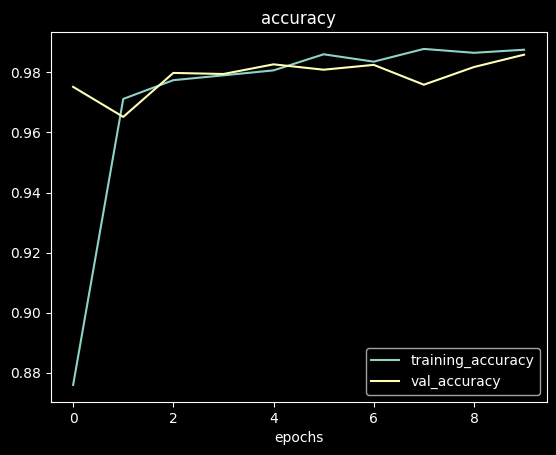

In [23]:
plot_loss_curves(history_alexnet)

LENET

In [24]:
model = keras.models.Sequential(
    [
      keras.layers.Input((28,28,1)),
      keras.layers.Conv2D(6, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Conv2D(16, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(120, activation='sigmoid'),
      keras.layers.Dense(84, activation='sigmoid'),
      keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [25]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
history_lenet = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10
1400/1400 [==============================] - 9s 5ms/step - loss: 0.9304 - accuracy: 0.7106 - val_loss: 0.2496 - val_accuracy: 0.9346
Epoch 2/10
1400/1400 [==============================] - 7s 5ms/step - loss: 0.1764 - accuracy: 0.9503 - val_loss: 0.1396 - val_accuracy: 0.9605
Epoch 3/10
1400/1400 [==============================] - 13s 10ms/step - loss: 0.1129 - accuracy: 0.9669 - val_loss: 0.1071 - val_accuracy: 0.9689
Epoch 4/10
1400/1400 [==============================] - 17s 12ms/step - loss: 0.0839 - accuracy: 0.9750 - val_loss: 0.0862 - val_accuracy: 0.9736
Epoch 5/10
1400/1400 [==============================] - 16s 12ms/step - loss: 0.0692 - accuracy: 0.9791 - val_loss: 0.0782 - val_accuracy: 0.9768
Epoch 6/10
1400/1400 [==============================] - 16s 11ms/step - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.0608 - val_accuracy: 0.9836
Epoch 7/10
1400/1400 [==============================] - 18s 13ms/step - loss: 0.0487 - accuracy: 0.9846 - val_loss: 0.0612 - val

In [27]:
with open('history_lenet.pkl', 'wb') as f:
    pickle.dump(history_lenet, f)

In [ ]:
with open('history_lenet.pkl', 'rb') as f:
    history_lenet = pickle.load(f)

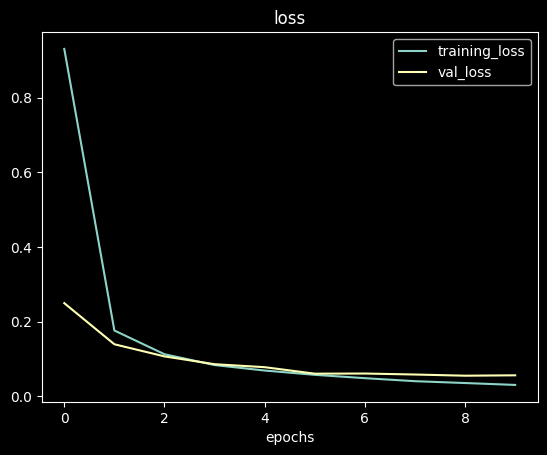

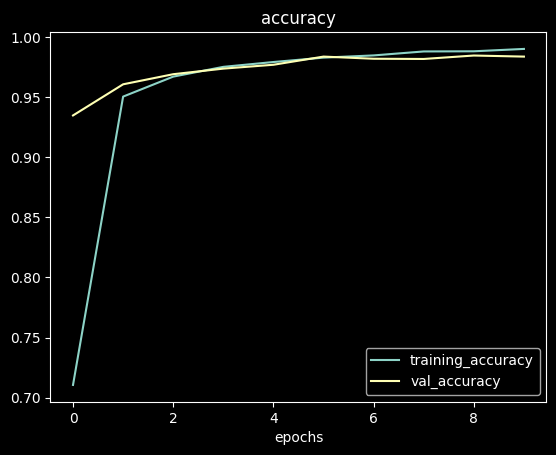

In [28]:
plot_loss_curves(history_lenet)

CUSTOM MODEL

In [6]:
model = keras.models.Sequential(
    [
      keras.layers.Input((28,28,1)),

      keras.layers.Conv2D(6, kernel_size=(5,5), activation='sigmoid'),
      keras.layers.Conv2D(12, kernel_size=(5,5), activation='sigmoid', padding='same'),

      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),
      keras.layers.Conv2D(16, kernel_size=(5,5), activation='sigmoid', padding='same'),
      keras.layers.Conv2D(32, kernel_size=(3,3), activation='sigmoid', padding='same'),
      keras.layers.Conv2D(32, kernel_size=(3,3), activation='sigmoid', padding='same'),
      keras.layers.MaxPool2D(pool_size=2, strides=(2,2)),

      keras.layers.Flatten(),
      keras.layers.Dense(120, activation='sigmoid'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(84, activation='sigmoid'),

      keras.layers.Dense(10, activation='softmax')
    ]
)

model.summary()

2024-03-06 13:35:53.029180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 13:35:53.483424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 13:35:53.483627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 13:35:53.489064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 13:35:53.489125: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 12)        1812      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 12)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        4816      
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 32)        9248      
                                                        

In [7]:
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [8]:
history_custom = model.fit(Xtrain, Ytrain,epochs=10, batch_size=16, validation_data=(Xtest,Ytest))

Epoch 1/10


2024-03-06 13:37:49.632850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 13:37:50.016948: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 13:37:51.243349: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 13:37:53.667679: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb3a2ac3d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 13:37:53.667713: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-06 13:37:53.674552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709707073.753866  250751 devic

1400/1400 [==============================] - 16s 6ms/step - loss: 1.4424 - accuracy: 0.4946 - val_loss: 0.3987 - val_accuracy: 0.8857
Epoch 2/10
1400/1400 [==============================] - 9s 6ms/step - loss: 0.3584 - accuracy: 0.8936 - val_loss: 0.3034 - val_accuracy: 0.9134
Epoch 3/10
1400/1400 [==============================] - 10s 7ms/step - loss: 0.2248 - accuracy: 0.9339 - val_loss: 0.1615 - val_accuracy: 0.9496
Epoch 4/10
1400/1400 [==============================] - 10s 7ms/step - loss: 0.1613 - accuracy: 0.9546 - val_loss: 0.1197 - val_accuracy: 0.9636
Epoch 5/10
1400/1400 [==============================] - 10s 7ms/step - loss: 0.1227 - accuracy: 0.9634 - val_loss: 0.0880 - val_accuracy: 0.9745
Epoch 6/10
1400/1400 [==============================] - 8s 6ms/step - loss: 0.0989 - accuracy: 0.9717 - val_loss: 0.0795 - val_accuracy: 0.9780
Epoch 7/10
1400/1400 [==============================] - 10s 7ms/step - loss: 0.0879 - accuracy: 0.9746 - val_loss: 0.0752 - val_accuracy: 0.977

In [9]:
with open('history_custom.pkl', 'wb') as f:
    pickle.dump(history_custom, f)

In [ ]:
with open('history_lenet.pkl', 'rb') as f:
    history_custom = pickle.load(f)

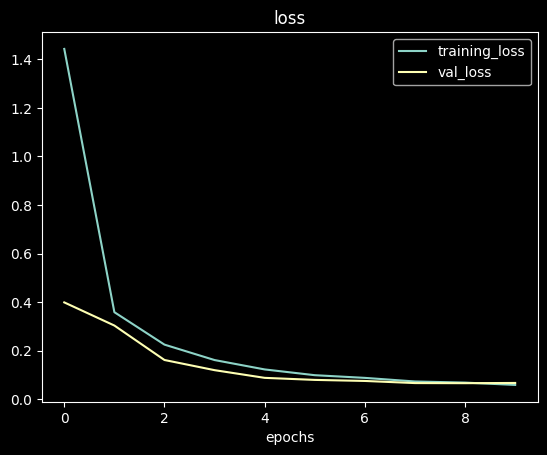

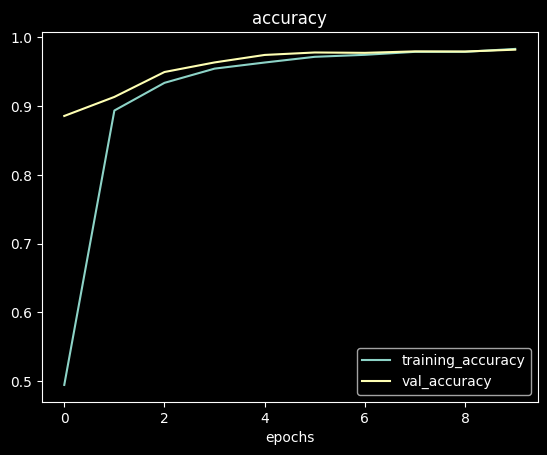

In [10]:
plot_loss_curves(history_custom)